In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state

In [2]:
def generate_noised_led_sample(
    n_sample=200, irrelevant=None, flip_proba=0.1, random_state=None
):
    random_state = check_random_state(random_state)

    data = np.array(
        [
            [0, 0, 1, 0, 0, 1, 0, 1],
            [1, 0, 1, 1, 1, 0, 1, 2],
            [1, 0, 1, 1, 0, 1, 1, 3],
            [0, 1, 1, 1, 0, 1, 0, 4],
            [1, 1, 0, 1, 0, 1, 1, 5],
            [1, 1, 0, 1, 1, 1, 1, 6],
            [1, 0, 1, 0, 0, 1, 0, 7],
            [1, 1, 1, 1, 1, 1, 1, 8],
            [1, 1, 1, 1, 0, 1, 1, 9],
            [1, 1, 1, 0, 1, 1, 1, 0],
        ]
    )

    data = data[random_state.randint(0, 10, n_sample)]
    X, y = np.array(data[:, :7], dtype=np.intp), data[:, 7]
    X_noised = np.zeros_like(X)
    for sample in range(n_sample):
        X_noised[sample, :] = np.abs(
            random_state.binomial(n=1, p=flip_proba, size=7) - X[sample, :]
        )
    if irrelevant:
        for proba in irrelevant:
            X_noised = np.hstack((X_noised, random_state.binomial(n=1, p=proba, size=n_sample)[:, np.newaxis]))
    return X_noised, y


In [4]:
warnings.filterwarnings(
    "ignore", message=r"Some inputs do not have OOB scores.*"
)
train_size = 250
flip_proba = 0.2
n_irrelevant = 9
n_features = 7 + n_irrelevant
n_rep = 100

n_estimators_list = np.logspace(1, 3, num=5, base=10, dtype="int")

rng = np.random.RandomState(0)
X, y = generate_noised_led_sample(
    n_sample=train_size,
    flip_proba=flip_proba,
    random_state=rng,
)

X = np.hstack((X, np.transpose([rng.randn(train_size) for _ in range(n_irrelevant)])))

repeated_results_ufi = np.zeros((len(n_estimators_list), n_features, n_rep))
repeated_results_mdi_oob = np.zeros((len(n_estimators_list), n_features, n_rep))

for i, n_estimators in enumerate(n_estimators_list):
    print(f"Training and computing FIs for {n_estimators} trees, repeated {n_rep} times ...")
    res_ufi = np.zeros((n_rep, n_features))
    res_mdi_oob = np.zeros((n_rep, n_features))
    for rep in range(n_rep):
        rfc = RandomForestClassifier(
            n_estimators=n_estimators,
            oob_score=True,
            n_jobs=-1,
            random_state=rng,
        ).fit(X, y)

        repeated_results_ufi[i, :, rep] = rfc.unbiased_feature_importances_
        repeated_results_mdi_oob[i, :, rep] = rfc._compute_ufi_and_oob_pred(X, y, sample_weight=None, method="MDI_oob")[0]


Training and computing FIs for 10 trees, repeated 100 times ...
Training and computing FIs for 31 trees, repeated 100 times ...
Training and computing FIs for 100 trees, repeated 100 times ...
Training and computing FIs for 316 trees, repeated 100 times ...
Training and computing FIs for 1000 trees, repeated 100 times ...


In [26]:
X_asymp, y_asymp = generate_noised_led_sample(n_sample=int(1e5), flip_proba=0.2)
rfc = RandomForestClassifier().fit(X_asymp, y_asymp)
MDI_asym = np.concat([rfc._unnormalized_feature_importances, n_irrelevant * [0]])

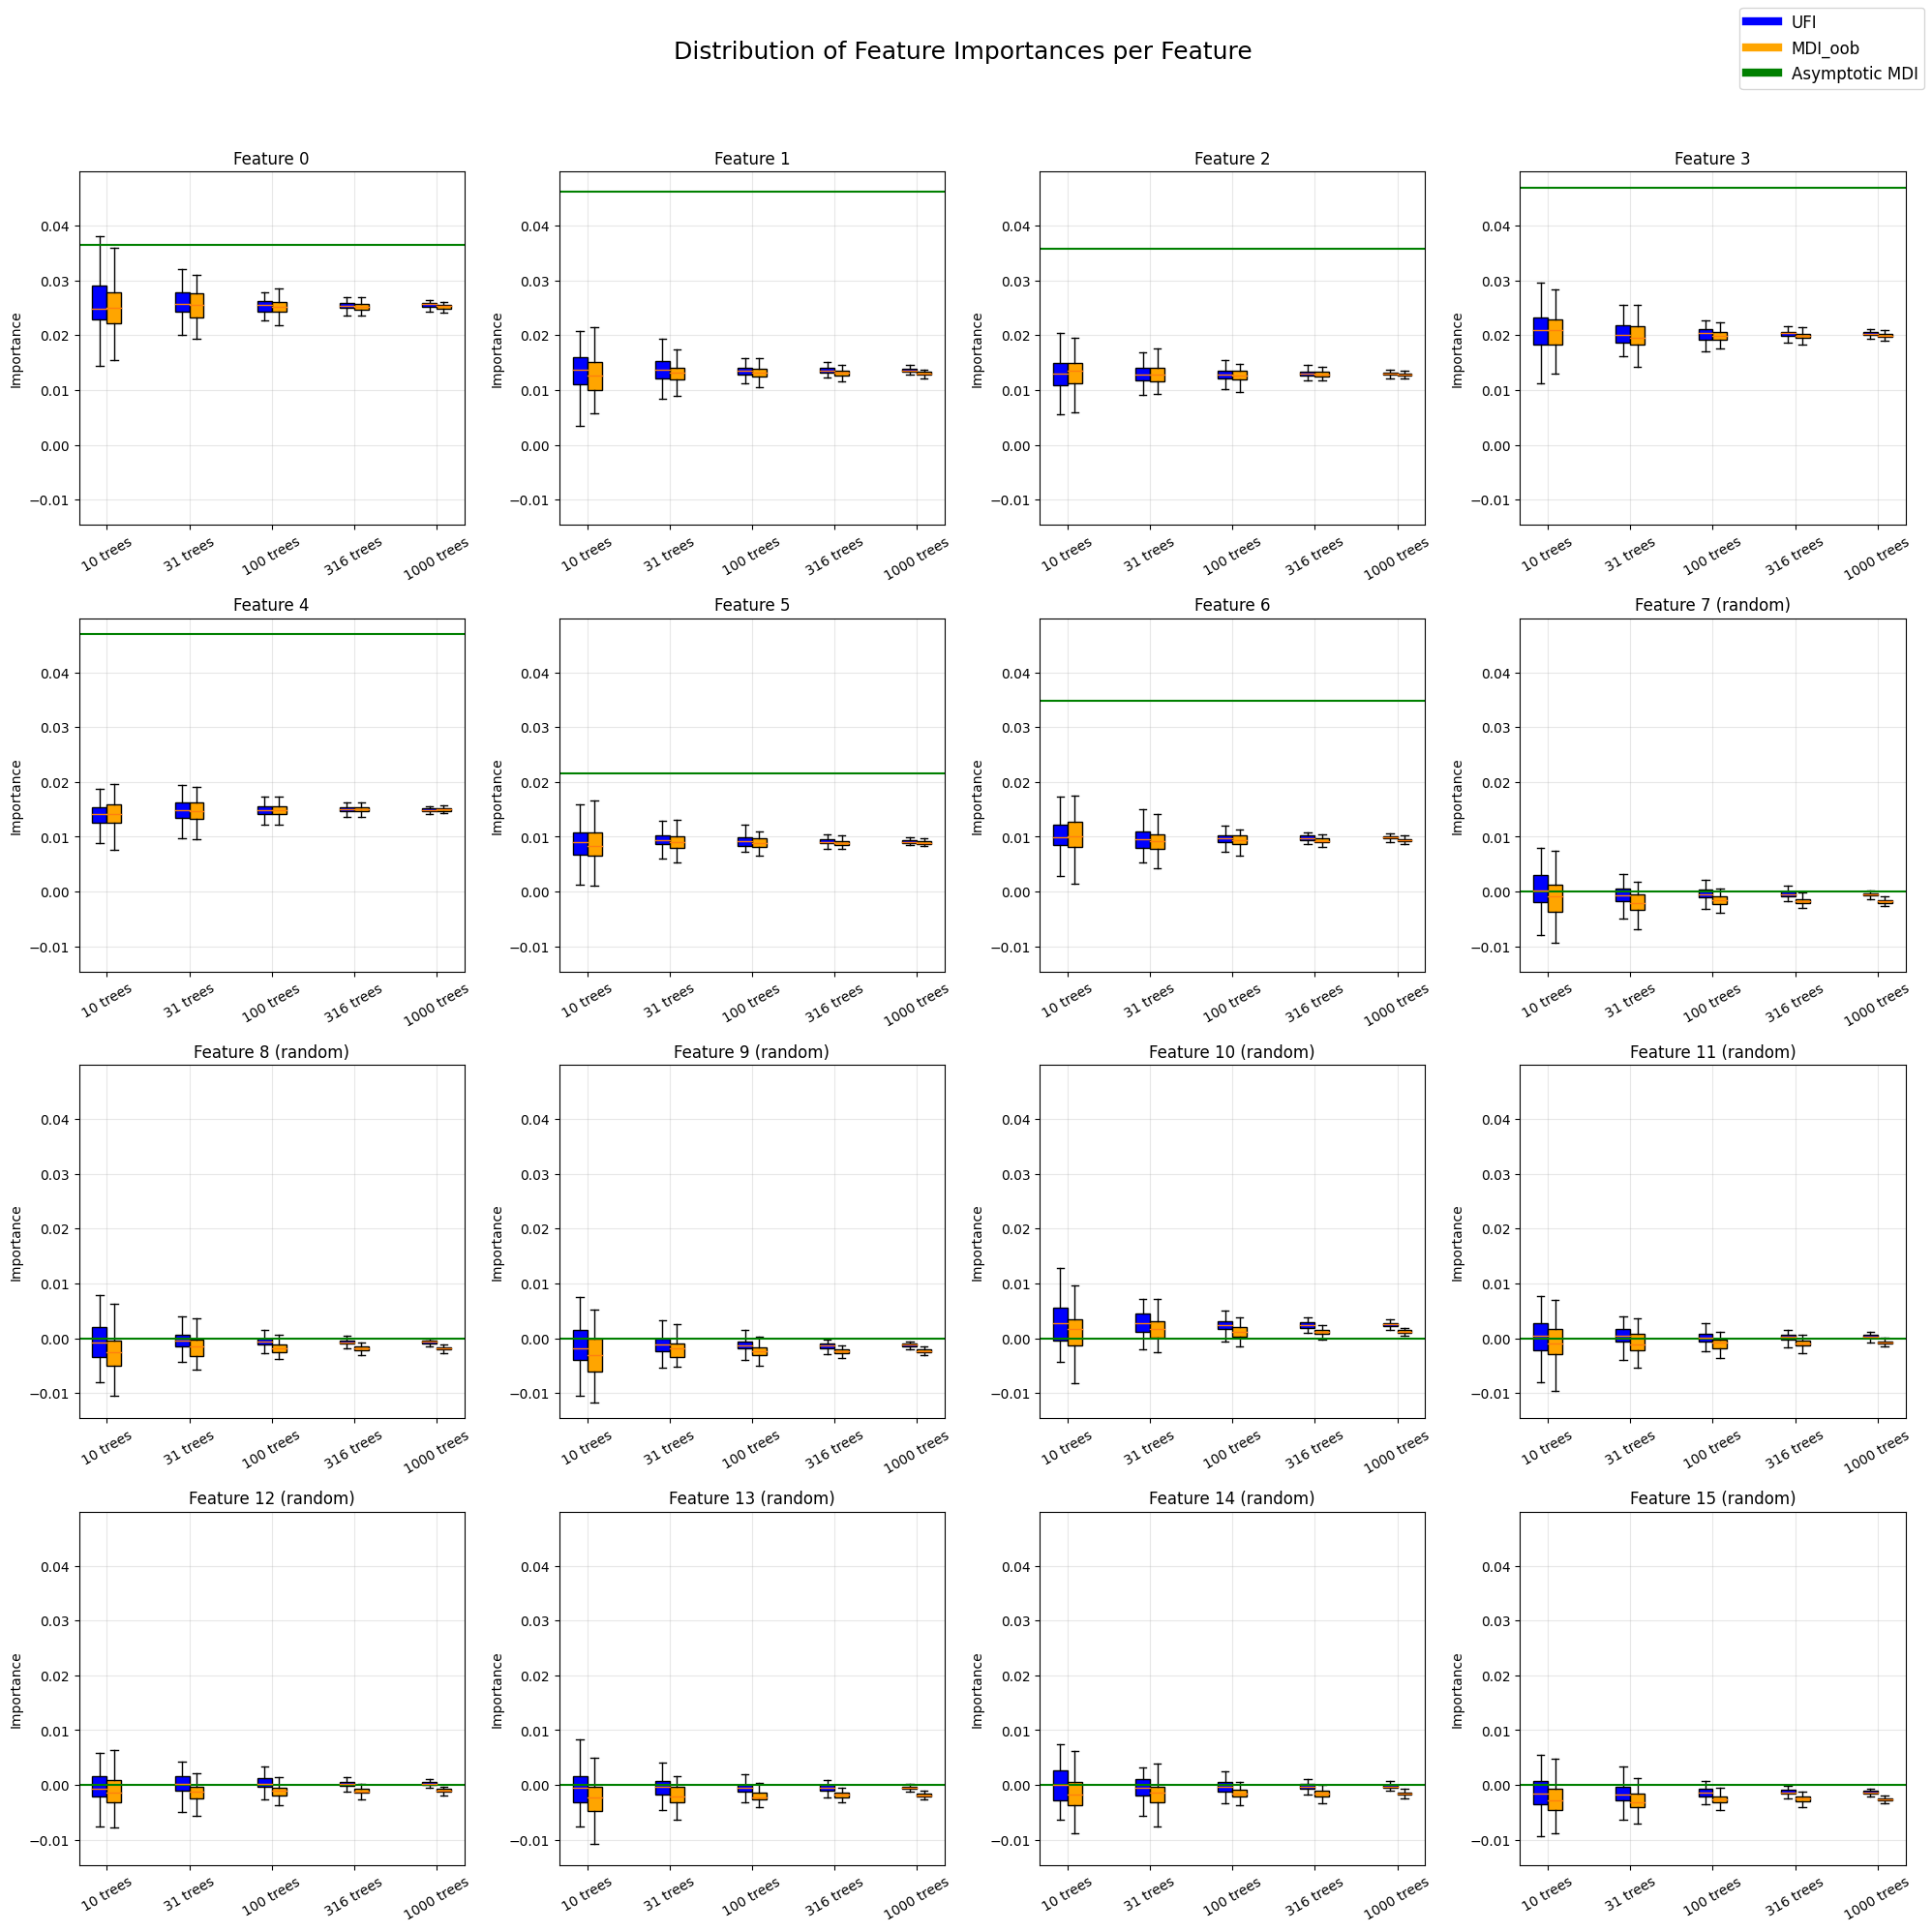

In [27]:
# Colors for the two methods
colors = {"UFI": "blue", "MDI_oob": "orange"}

ncols = 4
nrows = int(np.ceil(n_features / ncols))

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(20, 20), sharey=True
)
axes = axes.flatten()

width = 0.35  # spacing between UFI and MDI_oob boxes

for f_idx in range(n_features):
    ax = axes[f_idx]
    positions = []
    data = []
    colors_list = []
    labels = []

    for i, n_estimators in enumerate(n_estimators_list):
        # Base position for this n_estimators
        base_pos = i * 2  # keeps groups separated
        # Values
        ufi_vals = repeated_results_ufi[i, f_idx, :]
        mdi_vals = repeated_results_mdi_oob[i, f_idx, :]

        # Append UFI box
        positions.append(base_pos - width/2)
        data.append(ufi_vals)
        colors_list.append(colors["UFI"])
        labels.append(f"{n_estimators} trees")

        # Append MDI_oob box
        positions.append(base_pos + width/2)
        data.append(mdi_vals)
        colors_list.append(colors["MDI_oob"])
        labels.append(f"{n_estimators} trees")

    # Create the boxplot
    bp = ax.boxplot(
        data,
        positions=positions,
        widths=width,
        patch_artist=True,
        showfliers=False,
    )

    # Color boxes
    for patch, c in zip(bp["boxes"], colors_list):
        patch.set_facecolor(c)

    # Asymptotic MDI value
    ax.axhline(MDI_asym[f_idx], color="green")

    # Adjust x-axis
    ax.set_xticks([i * 2 for i in range(len(n_estimators_list))])
    ax.set_xticklabels([f"{n} trees" for n in n_estimators_list], rotation=30)

    ax.set_title(f"Feature {f_idx}" + " (random)"*(f_idx>6))
    ax.set_ylabel("Importance")
    ax.tick_params(labelleft=True)
    ax.grid(True, alpha=0.3)

# Remove unused axes
for j in range(f_idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Global legend
handles = [
    plt.Line2D([0], [0], color=colors["UFI"], lw=6, label="UFI"),
    plt.Line2D([0], [0], color=colors["MDI_oob"], lw=6, label="MDI_oob"),
    plt.Line2D([0], [0], color="green", lw=6, label="Asymptotic MDI"),
]
fig.legend(handles=handles, loc="upper right", fontsize=12)

fig.suptitle("Distribution of Feature Importances per Feature", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


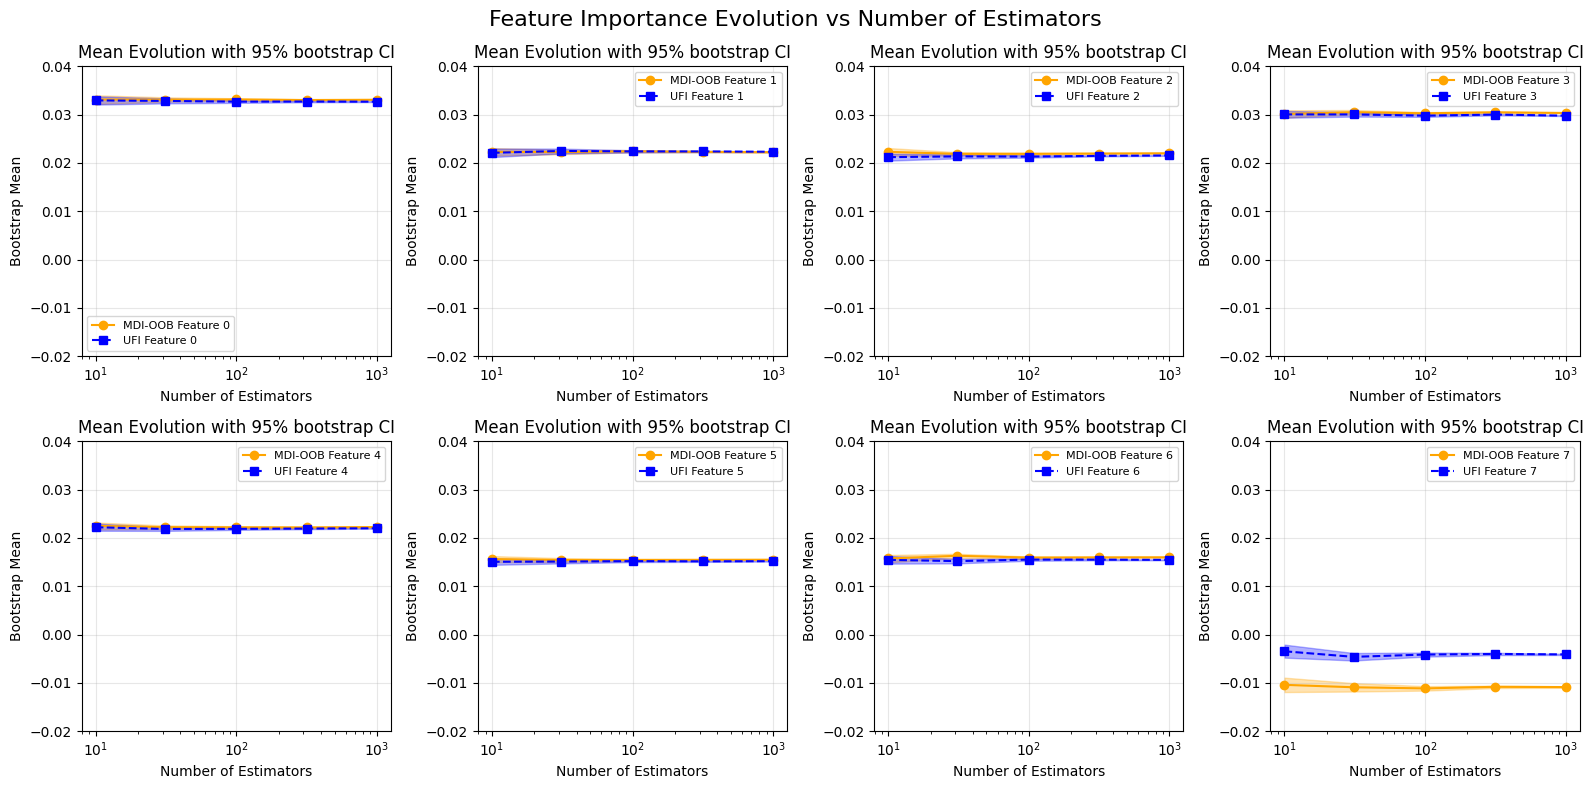

In [ ]:
bootstrap_results_ufi = dict(
    mean=np.zeros((len(n_estimators_list), n_features)),
    low=np.zeros((len(n_estimators_list), n_features)),
    high=np.zeros((len(n_estimators_list), n_features)),
)
bootstrap_results_mdi_oob = dict(
    mean=np.zeros((len(n_estimators_list), n_features)),
    low=np.zeros((len(n_estimators_list), n_features)),
    high=np.zeros((len(n_estimators_list), n_features)),
)

for i in range(len(n_estimators_list)):
    for feature_idx in range(n_features):
        bootstrap_results_ufi["mean"][i, feature_idx] = np.mean(
            repeated_results_ufi[i, feature_idx, :]
        )
        (
            bootstrap_results_ufi["high"][i, feature_idx],
            bootstrap_results_ufi["low"][i, feature_idx],
        ) = sp.stats.bootstrap(
            (repeated_results_ufi[i, feature_idx, :],), np.mean
        ).confidence_interval
        bootstrap_results_mdi_oob["mean"][i, feature_idx] = np.mean(
            repeated_results_mdi_oob[i, feature_idx, :]
        )
        (
            bootstrap_results_mdi_oob["high"][i, feature_idx],
            bootstrap_results_mdi_oob["low"][i, feature_idx],
        ) = sp.stats.bootstrap(
            (repeated_results_mdi_oob[i, feature_idx, :],), np.mean
        ).confidence_interval

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Feature Importance Evolution vs Number of Estimators", fontsize=16)
axes = axes.flatten()
for feature_idx in range(n_features):
    ax = axes[feature_idx]
    # MDI-OOB
    ax.plot(
        n_estimators_list,
        bootstrap_results_mdi_oob["mean"][:, feature_idx],
        "o-",
        color="orange",
        label=f"MDI-OOB Feature {feature_idx}",
    )
    ax.fill_between(
        n_estimators_list,
        bootstrap_results_mdi_oob["low"][:, feature_idx],
        bootstrap_results_mdi_oob["high"][:, feature_idx],
        alpha=0.3,
        color="orange",
    )

    # UFI
    ax.plot(
        n_estimators_list,
        bootstrap_results_ufi["mean"][:, feature_idx],
        "s--",
        color="blue",
        label=f"UFI Feature {feature_idx}",
    )
    ax.fill_between(
        n_estimators_list,
        bootstrap_results_ufi["low"][:, feature_idx],
        bootstrap_results_ufi["high"][:, feature_idx],
        alpha=0.3,
        color="blue",
    )

    ax.set_xlabel("Number of Estimators")
    ax.set_ylabel("Bootstrap Mean")
    ax.set_title("Mean Evolution with 95% bootstrap CI")
    ax.set_xscale("log")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    ax.set_ylim(-0.02, 0.04)

fig.tight_layout()